In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd

# Standard ISO Atmosphere
Only valid for altitudes below 11,000 meters

In [2]:
# Input is altitude in meters, output is temperature in Kelvin and pressure in Pascal
def ISO_atmosphere(alt, temp_offset):
    '''
    Input is altitude in meters.
    Returns a list of (Temperature, Pressure, Density, Viscosity)
    Units are (Kelvin, Pascals, kilograms/meter^3, Pascals * Seconds)
    '''
    p_sl = 101325 # Pa
    beta = -0.0065
    T_sl = 288.15 + temp_offset # K
    g_n = 9.80665 # m/s^2
    R = 287.05287 # J/(kg K)
    
    temp = T_sl - 0.0065 * alt
    pres = p_sl * (1 + beta / T_sl * (alt - 0))**(-g_n / (beta * R))
    dens = pres / (R * temp) # from ideal gas law
    visc = 18.27e-6 * (291.15+120)/(temp+120) * np.power((temp/291.15), (3/2))
    return(temp, pres, dens, visc)
    

In [3]:
ISO_atmosphere(0, 0)

(288.15, 101325.0, 1.225000018124288, 1.8120567104968423e-05)

# Ground Roll
Ground roll distance, equation 17.99 from Aircraft Design: A Conceptual Approach, D. P. Raymer.  
$S_G$, ground roll distance  
$T$, aircraft thrust -- correlate  
$W$, aircraft weight -- input parameter  
$\mu$, ground rolling resistance, assume $0.03$  
$\rho$, air density -- input parameter  
$S$, aircraft wing area, using $16.2 m^2$, verify with measurement ----------------------  
$C_{L,G}$, lift coefficient in ground effect, assume $0.1$  
$C_{D,0}$, parasitic drag coefficient  
$K$, induced drag factor  
$g$, gravity, $9.81 \frac{m}{s^2}$   
$V_i$, initial velocity, $0 \frac{m}{s}$  
$V_f$, final velocity  
$$S_G = \left(\frac{1}{2 \cdot g \cdot K_A} \right) \cdot \ln \left( \frac{K_T + K_A \cdot V_f^2}{K_T + K_A \cdot V_i^2} \right)$$
$$K_T = \frac{T}{W} - \mu$$
$$K_A = \frac{\rho}{2(W/S)} \cdot \left(\mu \cdot C_L - C_{D,0} - K \cdot C_L^2 \right)$$

In [4]:
mu = 0.03
S = 16.2 * u.m**2
C_LG = 0.1
g = 9.81 * u.m / u.s**2
V_i = 0 * u.m / u.s

## Thrust curve

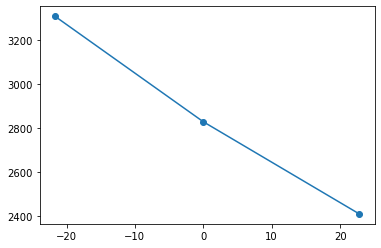

In [5]:
# Developed from M20C data
temp_offsets = [22.8, 0, -21.7]
thrusts = [2408.5, 2827.5, 3307.5]
fig, ax = plt.subplots()
ax.plot(temp_offsets, thrusts, "-o")

In [6]:
# looks linear, get coefficients and make a function
m, b = np.polyfit(temp_offsets, thrusts, 1)
def thrust(temp_offset):
    t = m * temp_offset + b
    return(t * u.N)

In [7]:
thrust(0)

<Quantity 2855.23517493 N>

## Ground Roll Function

In [8]:
def S_G(W, alt, temp_offset):
    # weight, altitude, offset temperature
    rho = ISO_atmosphere(alt, temp_offset)[2] * u.kg / u.m**3
    temp = ISO_atmosphere(alt, temp_offset)[0] * u.K
    T = thrust(temp_offset)
    
    K_T = T / W - mu
    K_A = rho / (2 * W / S) * (mu * C_LG - C_D0 - K * C_LG**2)
    S_G = (1/(2 * g * K_A)) * np.log((K_T + K_A * V_f**2)/(K_T + K_A * V_i**2))
    return(S_G, temp)

## Parasitic Drag Coefficient
$C_{fe}$, equivalent skin friction coefficient, $0.0055$  
$S_{wet}$, wetted area  
Assuming wetted area is 3 times wing reference area.  
From equation 12.23
$$ C_{D,0} = C_{fe} \cdot \frac{S_{wet}}{S} $$

In [9]:
C_D0 = 0.0055 * 3
C_D0

0.0165

##  Induced Drag Factor, K
$A$, aspect ratio, approximate as $\frac{10.67 m}{1.5 m}$, verify with measurement ------------------------------  
$e$, efficiency factor, assume $0.8$  
From equation 12.48  
$$K = \frac{1}{\pi \cdot A \cdot e}$$

In [10]:
A = 10.67 / 1.5
e = 0.8

In [11]:
K = 1 / (np.pi * A * e)
K

0.055935429858913546

## Final Velocity, $V_f = V_r$
$V_{so}$, stall speed, $57 \frac{mi}{hr}$
$$V_r = 1.2 * V_{so}$$

In [12]:
V_f = 1.2 * 57 * u.imperial.mile / u.hr

In [13]:
V_f

<Quantity 68.4 mi / h>

## Reproduce M20C Table

In [14]:
S_G(2200 * u.imperial.lbf, 0, 0)[0].to(u.imperial.foot)

<Quantity 613.02557821 ft>

### Sea Level

In [46]:
temp_offsets = [-21.7, 0, 22.7]
temperatures = []
ground_rolls = []
for temp_offset in temp_offsets:
    ground_roll = S_G(2200 * u.imperial.lbf, 0, temp_offset)[0].to(u.imperial.foot).value
    ground_rolls.append(ground_roll)
    temperature = S_G(2200 * u.imperial.lbf, 0, temp_offset)[1].to(u.imperial.deg_F, equivalencies=u.temperature()).value
    temperatures.append(temperature)

In [47]:
pd.set_option('display.float_format','{:.1f}'.format)
alt_0 = pd.DataFrame(
      {
          "Temp": temperatures,
          "Ground Roll": ground_rolls
      })
alt_0

,Temp,Ground Roll
0,19.9,522.4
1,59.0,613.0
2,99.9,749.1


### 2500 feet

In [48]:
S_G(2200 * u.imperial.lbf, 762, 0)[0].to(u.imperial.foot)

<Quantity 611.86895366 ft>